In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
# from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from sklearn.preprocessing import normalize

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

0:year,1:Start_date,2:ProfitLoss,3:GrossResult,4:Assets,5:AverageNumberOfEmployees,6:Equity,7:AddressOfReportingEntityPostCodeIdentifier

In [4]:
years = 6
data = np.load('data_train_{}.npy'.format(years),allow_pickle=True)
target = np.load('data_target_{}.npy'.format(years),allow_pickle=True)

In [5]:
#Changes address to first number in postcode or 0 if there isn't one
data = data[:,:,2:] 
target = target[:,2:]
'''
0:ProfitLoss,1:GrossResult,2:Assets,3:AverageNumberOfEmployees,4:Equity,5:AddressOfReportingEntityPostCodeIdentifier
'''
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,5] = int(str(data[i,j,5])[0])
        except:
            data[i,j,5] = 0
for i in range(target.shape[0]):
    try:
        target[i,5] = int(str(target[i,5])[0])
    except:
        target[i,5] = 0

In [6]:
#remove remaining strings
index_of_string = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            try:
                float(data[i,j,k])
            except:
                index_of_string.append((i))
                
index_of_string = np.array(index_of_string)
index_of_string = np.unique(index_of_string)                
data = np.delete(data,index_of_string,axis=0)
target = np.delete(target,index_of_string,axis=0)

D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]
D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


In [7]:
#remove nan
nan_ = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            if np.isnan(data[i,j,k]):
                nan_.append(i)
nan_ = np.array(nan_)
nan_ = np.unique(nan_)
data = np.delete(data,nan_,axis=0)
target = np.delete(target,nan_,axis=0)

D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
D:\Programmer\Anaconda\envs\Deep learning\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#removes any entry with a zero in profitloss, GrossResult, assets or equity
has_zero = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data[i,j,0] == 0 or data[i,j,1] == 0 or data[i,j,2] == 0 or data[i,j,4] == 0:
            has_zero.append(i)
has_zero = np.unique(np.array(has_zero))
data = np.delete(data,has_zero,axis=0)
target = np.delete(target,has_zero,axis=0)

In [9]:
# big_company_pos = []
# medium_company_pos = []
# small_company_pos = []
# big_company_neg = []
# medium_company_neg = []
# small_company_neg = []

# for i in range(data.shape[0]):
#     if np.median(data[i,:,1]) < 0:
#         if np.mean(data[i,:,2]) < 100000:
#             small_company_neg.append(i)
#         elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
#             medium_company_neg.append(i)
#         else:
#             big_company_neg.append(i)
#     else:
#         if np.mean(data[i,:,2]) < 100000:
#             small_company_pos.append(i)
#         elif np.mean(data[i,:,2]) > 100000 and np.mean(data[i,:,2]) < 10000000:
#             medium_company_pos.append(i)
#         else:
#             big_company_pos.append(i)

# print(len(small_company_neg))
# print(len(small_company_pos))
# print(len(medium_company_neg))
# print(len(medium_company_pos))
# print(len(big_company_neg))
# print(len(big_company_pos))

In [10]:
small_company = []
medium_company = []
big_company = []
for i in range(data.shape[0]):
    if np.mean(data[i,:,2]) < 1000000:
        small_company.append(i)
    elif np.mean(data[i,:,2]) > 1000000 and np.mean(data[i,:,2]) < 10000000:
        medium_company.append(i)
    else:
        big_company.append(i)
        
print(len(small_company))        
print(len(medium_company))
print(len(big_company))

1366
2973
1394


In [11]:
data = data.astype("float")
target = target.astype("float")

In [12]:
# data = data[medium_company_pos]
# target = target[medium_company_pos]
# data = data[small_company]
# target = target[small_company]
data = data[medium_company]
target = target[medium_company]

In [13]:
data = data[:,:,0:3]
features = data.shape[2]

In [14]:
data = torch.from_numpy(data).float()
# data = data.permute(0,2,1) # Needed if using CNN
target = torch.from_numpy(target).float()

#target index
target_index = 1

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,:]
train_target = target[train_idx,target_index] 
test_data = data[test_idx,:,:]
test_target = target[test_idx,target_index]

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [15]:
# #for data_grouped.npy
# zeros_ = np.zeros(6)
# for i in range(6):
#     temp = data[:,:,i].clone()
#     zeros_[i] = temp[temp==0].shape[0]
    
# pct_zeros = zeros_/(data.shape[0]*3)
# print('0:ProfitLoss, 1:GrossResult, 2:Assets,3:AverageNumberOfEmployees, 4:Equity, 5:AddressOfReportingEntityPostCodeIdentifier')
# print(pct_zeros)

In [16]:
batch_size=100

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
# temp = data.clone()
# temp = temp.view(temp.shape[0]*temp.shape[1],temp.shape[2])
# temp = temp.numpy()

# # #standardize data 
# temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
# temp = temp*(1/np.std(temp,0))
# #compute covariance matrix
# S = np.cov(temp.T)

# #obtain eigen values and eigen vectors
# eigenValues, eigenVectors = eigh(S)
# idx_ord = np.argsort(eigenValues)[::-1]
# eigenValues = eigenValues[idx_ord]
# eigenVectors = eigenVectors[:,idx_ord]

# #plot cummulative variance explained    
# summ = eigenValues.sum()
# cumsum = 0
# total_var_explained = np.zeros(features)
# for i in range(features):    
#     cumsum = cumsum + eigenValues[i]
#     total_var_explained[i]=(cumsum/summ)
    
# fig, ax = plt.subplots()
# ax.plot(total_var_explained,'-o')
# #ax.axhline(0.90,linestyle='--')
# plt.grid();
# #plt.xlim(-1,50)
# #plt.ylim(0,1)
# plt.title('Variance explained' )
# plt.ylabel('Cummulative sum')
# plt.xlabel('Principle components')
# # plt.savefig("variance_explained")
# plt.show()

# M=features
# pcs = np.arange(features)
# #pcs = np.array([3,10])
# legendStrs = ['PC'+str(e+1) for e in pcs]
# c = ['r','g','b']
# bw = .15
# r = np.arange(1,M+1)
# for i in pcs:    
#    plt.bar(r+i*bw/2, eigenVectors[:,i], width=bw)
# plt.xticks(r+bw, np.arange(1,13))
# plt.xlabel('Attributes')
# plt.ylabel('Component coefficients')
# plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
# plt.grid()
# plt.title('PCA Component Coefficients')
# plt.show()

In [18]:
# #Picking principle components to project the data into
# eigenvectors1 = eigenVectors[:, 0]
# eigenvectors2 = eigenVectors[:, 1]
# eigenvectors3 = eigenVectors[:, 2]
# eigenvectors4 = eigenVectors[:, 3]
# eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

# ## now we have to project our vectors in this new base
# transformed_data = temp @ eigenvectors

# fig,ax = plt.subplots(3,1,figsize=(10,15))
# ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
# ax[0].set_title('Data projection into 2D PC space')
# ax[0].set_xlabel('Principle component 1')
# ax[0].set_ylabel('Principle component 2')
# ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
# ax[1].set_title('Data projection into 2D PC space')
# ax[1].set_xlabel('Principle component 1')
# ax[1].set_ylabel('Principle component 3')
# ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
# ax[2].set_title('Data projection into 2D PC space')
# ax[2].set_xlabel('Principle component 1')
# ax[2].set_ylabel('Principle component 4')
# #plt.rcParams.update({'figure.autolayout': True})
# plt.show()

In [19]:
class RecurrentNetSkip(nn.Module):
    def __init__(self,years,p):
        super(RecurrentNetSkip, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=features,
                          hidden_size=10,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=(10+features)*years,out_features=50),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,6]
        
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         z = torch.cat(temp,dim=1) #[batch_size,3,6]
        
#         y = torch.cat((z,x),dim=2) #[batch_size,3,12]
                                            
        y,_ = self.rnn(x) #[batch_size,years,50]
        
        x = torch.cat((x,y),dim=2) #[batch_size,years,50+3]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,(50+3)*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [20]:
class RecurrentNet(nn.Module):
    def __init__(self,years,p):
        super(RecurrentNet, self).__init__()
        
#         self.linearIn = nn.Sequential(nn.Linear(in_features=years,out_features=6),
#                                       nn.ReLU(),
#                                       nn.Linear(6,10)) 
        self.rnn = nn.GRU(input_size=features,
                          hidden_size=10,
                          num_layers=years,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=10*years,out_features=50),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(50,20),
                                       nn.ReLU(),
                                       nn.Dropout(p=p),
                                       nn.Linear(20,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,years,3]
#         x1 = self.linearIn(x[:,0,:]) #[batch_size,6]
#         x2 = self.linearIn(x[:,1,:]) #[batch_size,6]
#         x3 = self.linearIn(x[:,2,:]) #[batch_size,6]
#         x1 = x1.unsqueeze(1) #[batch_size,1,6]
#         x2 = x2.unsqueeze(1) #[batch_size,1,6]
#         x3 = x3.unsqueeze(1) #[batch_size,1,6]     
#         temp = []
#         temp.append(x1)
#         temp.append(x2)
#         temp.append(x3)
#         x = torch.cat(temp,dim=1) #[batch_size,3,6]
                                            
        x,_ = self.rnn(x) #[batch_size,years,50]
        
        x = x.reshape(x.shape[0],-1) #[batch_size,50*years]
                       
        x = self.linearOut(x) #[batch_size,1], [batch_size,2] if predicting normal distribution
        x = x.view(-1)
        return x


In [21]:
class LinearNet(nn.Module):
    def __init__(self,years,p):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=features*years,out_features=40),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(40,60),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(60,20),
                                   nn.ReLU(),
                                   nn.Dropout(p=p),
                                   nn.Linear(20,1))

        
    def forward(self, x): #x = [batch_size,3,3]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [22]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))

def percent_loss(pred,target):
    count_bad_pred = 0
    temp = pred < torch.ones(pred.shape[0])*1000
    temp2 = pred > torch.ones(pred.shape[0])*-1000
    for i in range(pred.shape[0]):
        if temp[i] == temp2[i]:
            count_bad_pred += 1

    return torch.sum(torch.abs(torch.abs(pred-target)/(target+1)))+count_bad_pred*10000

In [23]:
model1 = LinearNet(years,0.15)
model2 = RecurrentNet(years,0.15)
model3 = RecurrentNetSkip(years,0.15)

# model1 = RecurrentNet(years,0.15)

model1.to(device)
model2.to(device)
model3.to(device)
lr = 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)

critirion = nn.SmoothL1Loss()

In [24]:
#Training loop
num_epochs = 50
train_loss1 = []
test_loss1 = []
train_loss2 = []
test_loss2 = []
train_loss3 = []
test_loss3 = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error1 = 0
    train_error2 = 0
    train_error3 = 0
    model1.train()
    model2.train()
    model3.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        #Forward pass your image through the network
        output1 = model1(data)
        output2 = model2(data)
        output3 = model3(data)
        #Compute the loss
#         loss1 = percent_loss(output1,target)
#         loss2 = percent_loss(output2,target)
#         loss3 = percent_loss(output3,target)
        loss1 = critirion(output1,target)
        loss2 = critirion(output2,target)
        loss3 = critirion(output3,target)

        #Backward pass through the network
        loss1.backward()
        loss2.backward()
        loss3.backward()
        #Update the weights
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        train_error1 += loss1
        train_error2 += loss2
        train_error3 += loss3
        
        
    #Comput the test accuracy
    model1.eval()
    model2.eval()
    model3.eval()
    test_error1 = 0
    test_error2 = 0
    test_error3 = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output1 = model1(data)
            output2 = model2(data)
            output3 = model3(data)
#         test_error1 += percent_loss(output1,target)
#         test_error2 += percent_loss(output2,target)
#         test_error3 += percent_loss(output3,target)
        test_error1 += critirion(output1,target)
        test_error2 += critirion(output2,target)
        test_error3 += critirion(output3,target)
        
    train_err1 = train_error1/len(trainset)
    train_loss1.append(train_err1)
    test_err1 = test_error1/len(testset)
    test_loss1.append(test_err1)
    train_err2 = train_error2/len(trainset)
    train_loss2.append(train_err2)
    test_err2 = test_error2/len(testset)
    test_loss2.append(test_err2)
    train_err3 = train_error3/len(trainset)
    train_loss3.append(train_err3)
    test_err3 = test_error3/len(testset)
    test_loss3.append(test_err3)
    print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}\n train error 2: {train2:.1f}\t test error 2: {test2:.1f}\n train error 3: {train3:.1f}\t test error 3: {test3:.1f}".format(test1=test_err1, test2=test_err2, test3=test_err3, train1=train_err1, train2=train_err2, train3=train_err3))
#     print("train error 1: {train1:.1f}\t test error 1: {test1:.1f}".format(test1=test_err1,train1=train_err1))


train error 1: 14991.5	 test error 1: 9884.9
 train error 2: 16222.9	 test error 2: 12890.6
 train error 3: 14948.5	 test error 3: 10032.9



train error 1: 9854.5	 test error 1: 6919.7
 train error 2: 16179.2	 test error 2: 12890.6
 train error 3: 10145.2	 test error 3: 6061.4



train error 1: 7618.1	 test error 1: 5585.2
 train error 2: 16198.6	 test error 2: 12890.6
 train error 3: 7298.1	 test error 3: 5278.4



train error 1: 6737.2	 test error 1: 5101.3
 train error 2: 16249.2	 test error 2: 12890.4
 train error 3: 6277.7	 test error 3: 4837.1



train error 1: 6305.4	 test error 1: 4824.5
 train error 2: 16318.0	 test error 2: 12890.2
 train error 3: 5642.1	 test error 3: 4675.5



train error 1: 6381.5	 test error 1: 4690.8
 train error 2: 16203.5	 test error 2: 12889.6
 train error 3: 5734.0	 test error 3: 4640.5



train error 1: 5811.6	 test error 1: 4552.4
 train error 2: 16182.0	 test error 2: 12888.7
 train error 3: 5389.6	 test error 3: 4528.9



train error 1: 5604.5	 test error 1: 4502.0
 train error 2: 16189.3	 test error 2: 12887.3
 train error 3: 5315.4	 test error 3: 4410.6



train error 1: 5665.9	 test error 1: 4506.2
 train error 2: 16237.4	 test error 2: 12885.1
 train error 3: 5275.6	 test error 3: 4344.0



train error 1: 5614.4	 test error 1: 4533.5
 train error 2: 16233.4	 test error 2: 12882.1
 train error 3: 5131.9	 test error 3: 4320.8



train error 1: 5298.8	 test error 1: 4390.2
 train error 2: 16169.0	 test error 2: 12879.2
 train error 3: 5185.1	 test error 3: 4340.6



train error 1: 5203.5	 test error 1: 4549.6
 train error 2: 16175.4	 test error 2: 12873.9
 train error 3: 5166.5	 test error 3: 4402.8



train error 1: 5362.4	 test error 1: 4260.9
 train error 2: 16170.2	 test error 2: 12868.1
 train error 3: 5044.0	 test error 3: 4248.2



train error 1: 5240.5	 test error 1: 4291.0
 train error 2: 16203.2	 test error 2: 12862.0
 train error 3: 5014.3	 test error 3: 4369.0



train error 1: 5331.8	 test error 1: 4280.1
 train error 2: 16131.3	 test error 2: 12854.3
 train error 3: 4946.0	 test error 3: 4381.5



train error 1: 5084.6	 test error 1: 4283.3
 train error 2: 16146.8	 test error 2: 12845.9
 train error 3: 5048.7	 test error 3: 4282.9



train error 1: 5299.9	 test error 1: 4407.1
 train error 2: 16135.1	 test error 2: 12837.0
 train error 3: 4978.3	 test error 3: 4226.2



train error 1: 5186.1	 test error 1: 4264.3
 train error 2: 16158.2	 test error 2: 12824.6
 train error 3: 4838.6	 test error 3: 4192.9



train error 1: 4979.2	 test error 1: 4269.4
 train error 2: 16139.5	 test error 2: 12815.0
 train error 3: 4859.8	 test error 3: 4240.9



train error 1: 5182.3	 test error 1: 4290.0
 train error 2: 16080.2	 test error 2: 12804.0
 train error 3: 4883.0	 test error 3: 4186.7



train error 1: 5037.7	 test error 1: 4295.6
 train error 2: 16095.1	 test error 2: 12789.7
 train error 3: 4785.5	 test error 3: 4298.5



train error 1: 4955.5	 test error 1: 4236.8
 train error 2: 16147.2	 test error 2: 12777.8
 train error 3: 5026.5	 test error 3: 4287.0



train error 1: 5056.7	 test error 1: 4558.1
 train error 2: 16085.4	 test error 2: 12764.3
 train error 3: 4841.3	 test error 3: 4311.1



train error 1: 5067.5	 test error 1: 4314.2
 train error 2: 16059.0	 test error 2: 12750.9
 train error 3: 4911.6	 test error 3: 4242.7



train error 1: 4986.8	 test error 1: 4215.9
 train error 2: 16035.4	 test error 2: 12732.7
 train error 3: 4732.5	 test error 3: 4322.2



train error 1: 5036.2	 test error 1: 4263.9
 train error 2: 16048.6	 test error 2: 12717.1
 train error 3: 4734.1	 test error 3: 4250.3



train error 1: 4850.9	 test error 1: 4423.4
 train error 2: 16018.3	 test error 2: 12701.8
 train error 3: 4670.6	 test error 3: 4210.6



train error 1: 4937.9	 test error 1: 4315.4
 train error 2: 15998.2	 test error 2: 12676.0
 train error 3: 4782.1	 test error 3: 4266.5



train error 1: 4998.2	 test error 1: 4449.2
 train error 2: 16003.0	 test error 2: 12657.2
 train error 3: 4796.8	 test error 3: 4248.1



train error 1: 4895.9	 test error 1: 4607.4
 train error 2: 15892.6	 test error 2: 12636.4
 train error 3: 4798.8	 test error 3: 4347.1



train error 1: 4978.0	 test error 1: 4532.5
 train error 2: 15915.1	 test error 2: 12611.3
 train error 3: 4874.2	 test error 3: 4573.8



train error 1: 5098.6	 test error 1: 4338.8
 train error 2: 15970.1	 test error 2: 12594.6
 train error 3: 4792.9	 test error 3: 4258.3



train error 1: 5080.3	 test error 1: 4543.7
 train error 2: 15878.3	 test error 2: 12566.3
 train error 3: 4732.1	 test error 3: 4287.3



train error 1: 5001.5	 test error 1: 4401.6
 train error 2: 15837.7	 test error 2: 12542.7
 train error 3: 4585.8	 test error 3: 4255.5



train error 1: 5042.8	 test error 1: 4361.6
 train error 2: 15811.0	 test error 2: 12519.5
 train error 3: 4743.2	 test error 3: 4277.1



train error 1: 4984.4	 test error 1: 4290.9
 train error 2: 15813.7	 test error 2: 12482.5
 train error 3: 4764.7	 test error 3: 4302.9



train error 1: 4884.8	 test error 1: 4536.4
 train error 2: 15801.2	 test error 2: 12466.7
 train error 3: 4658.9	 test error 3: 4276.2



train error 1: 4964.1	 test error 1: 4284.9
 train error 2: 15693.9	 test error 2: 12425.0
 train error 3: 4815.4	 test error 3: 4251.9



train error 1: 4871.5	 test error 1: 4422.8
 train error 2: 15687.3	 test error 2: 12387.7
 train error 3: 4654.4	 test error 3: 4311.9



train error 1: 4730.4	 test error 1: 4334.2
 train error 2: 15682.5	 test error 2: 12367.0
 train error 3: 4746.7	 test error 3: 4244.6



train error 1: 4688.0	 test error 1: 4254.4
 train error 2: 15601.5	 test error 2: 12323.8
 train error 3: 4687.5	 test error 3: 4197.5



train error 1: 4849.3	 test error 1: 4320.1
 train error 2: 15600.9	 test error 2: 12294.5
 train error 3: 4641.2	 test error 3: 4306.9



train error 1: 4826.3	 test error 1: 4292.1
 train error 2: 15500.3	 test error 2: 12269.2
 train error 3: 4651.4	 test error 3: 4298.6



train error 1: 4936.3	 test error 1: 4331.4
 train error 2: 15479.4	 test error 2: 12238.1
 train error 3: 4571.3	 test error 3: 4269.9



train error 1: 4879.3	 test error 1: 4296.4
 train error 2: 15466.4	 test error 2: 12194.6
 train error 3: 4749.4	 test error 3: 4284.9



train error 1: 4670.4	 test error 1: 4359.1
 train error 2: 15411.5	 test error 2: 12161.2
 train error 3: 4869.4	 test error 3: 4276.6



train error 1: 4827.2	 test error 1: 4360.2
 train error 2: 15385.7	 test error 2: 12126.2
 train error 3: 4820.7	 test error 3: 4212.5



train error 1: 4632.7	 test error 1: 4490.3
 train error 2: 15339.0	 test error 2: 12091.2
 train error 3: 4740.2	 test error 3: 4244.8



train error 1: 4664.1	 test error 1: 4737.7
 train error 2: 15299.8	 test error 2: 12064.4
 train error 3: 4805.7	 test error 3: 4251.9



train error 1: 4840.9	 test error 1: 4409.3
 train error 2: 15282.6	 test error 2: 12003.0
 train error 3: 4657.1	 test error 3: 4325.0



In [25]:
print(target[:10])
temp =model1(data[:10])
print(temp)

tensor([ 2.9261e+05, -2.5003e+04,  2.9409e+06, -7.2613e+05,  2.5298e+05,
         3.4519e+06, -8.4250e+03, -7.6370e+03,  3.6884e+06,  1.2338e+07],
       device='cuda:0')
tensor([ 2.0605e+06, -1.2024e+04,  3.7079e+06, -6.0043e+04,  4.0805e+05,
         2.7151e+06, -6.7187e+03, -4.5421e+03,  2.9975e+06,  1.1240e+07],
       device='cuda:0', grad_fn=<ViewBackward>)


In [26]:
#predicts the average over the last 3 years
baseline_loss = 0
for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):  
    y_pred = data[:,:,0].mean(1)
#     y_pred = data.mean(1)
    loss = critirion(y_pred,target)
#     loss = percent_loss(y_pred,target)
    baseline_loss += loss.numpy()
baseline_loss /= len(trainset)
print("baseline error: {error:.1f}".format(error =baseline_loss))


baseline error: 16625.6


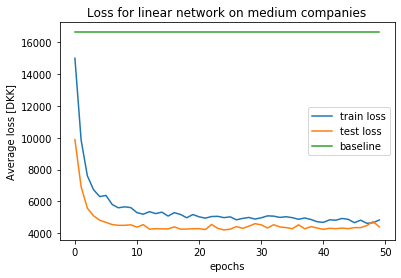

In [27]:
plt.plot(train_loss1)
plt.plot(test_loss1)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for linear network on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
plt.savefig("../images/linear_loss_{}_features_{}_years".format(features,years))
plt.show()

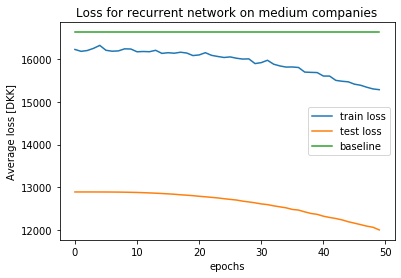

In [28]:
plt.plot(train_loss2)
plt.plot(test_loss2)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for recurrent network on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
plt.savefig("../images/recurrent_loss_{}_features_{}_years".format(features,years))
plt.show()

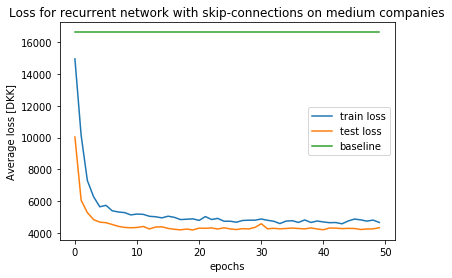

In [29]:
plt.plot(train_loss3)
plt.plot(test_loss3)
plt.plot(np.ones(num_epochs)*baseline_loss)
plt.legend(["train loss","test loss","baseline"])
plt.title("Loss for recurrent network with skip-connections on medium companies")
plt.xlabel("epochs")
plt.ylabel("Average loss [DKK]")
plt.savefig("../images/recurrentskip_loss_{}_features_{}_years".format(features,years))
plt.show()

In [30]:
torch.save(model1.state_dict(),"linear_network_{}_features_{}_years".format(features,years))
torch.save(model2.state_dict(),"recurrent_network_{}_features_{}_years".format(features,years))
torch.save(model3.state_dict(),"recurrent_skip_network_{}_features_{}_years".format(features,years))